# Library Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import itertools
import cv2

!pip install torchviz
from torch.utils.data.sampler import SubsetRandomSampler
from torch.autograd import Variable
from torchviz import make_dot
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms
import torch.optim as optim
import time
from os import listdir
from os.path import isfile, join
import os
from google.colab.patches import cv2_imshow

# Recognizing Handwritten Math Equations

# Introduction

## Our Project
For our project, we explored handwritten math recognition. Our goal was to create a machine learning model to determine the mathematical symbols in an equation. Math recognition is applicable to education, especially online schooling where it could be helpful to digitize students' math work. It would also enable greater sharing and collaboration ability in virtual spaces.
 
## Our Model
We implemented handwritten math recognition using a convolutional neural network (CNN) model. CNNs are composed of pooling and convolutional layers which perform preprocessing steps, and fully connected layers in which every input of one layer is connected to every activation unit of the next layer by some weight. CNNs are useful in computer vision applications because they reduce the amount of computation and data storage through pooling, and use kernels to pull useful features like edges from an image.


## Load and Preprocess Data
 
We used a [Kaggle Handwritten Math Symbol and Digit Dataset](https://www.kaggle.com/sagyamthapa/handwritten-math-symbols) to train, validate, and test our CNN. We split our dataset into 7557 training images and 1010 test images with 16 classes. The classes were the numerical digits 0-9, multiplication, division, addition, and subtraction signs, the equals sign, and decimal point. The training dataset included approximately the same number of images of each class as shown in Figure 2. The images in this dataset range from 130 to 155 pixels wide and tall, so to preprocess them we used a center crop to make them all the same size and square. Since the images were already in black and white, we then convert them into greyscale to remove redundant color channels. Lastly, we resized all of the images to be smaller (32x32 pixels). By converting all of the images into greyscale and downsizing them we increased the speed of model training by decreasing the data stored in each image without losing critical information.

In [ ]:
!unzip Math_handwriting.zip &> /dev/null

In [ ]:
# Load the training set
crop_dims = [3, 130, 130]
image_dims = [1, 32, 32]
transform = transforms.Compose([transforms.CenterCrop((crop_dims[1], crop_dims[2])), transforms.Grayscale(num_output_channels=1), transforms.Resize(image_dims[1]), transforms.ToTensor()])

batch_size = 32

data_dir_test = "Math_handwriting1/eval"
test_data = torchvision.datasets.ImageFolder(data_dir_test, transform=transform)
print("len(test_data) =", len(test_data))
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)


data_dir_train = "Math_handwriting1/train"
train_data = torchvision.datasets.ImageFolder(data_dir_train, transform=transform)
print("len(train_data) =", len(train_data))
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
print("Classes=", train_data.classes)

len(test_data) = 1010
len(train_data) = 7557
Classes= ['decimal', 'div', 'eight', 'equal', 'five', 'four', 'minus', 'nine', 'one', 'plus', 'seven', 'six', 'three', 'times', 'two', 'zero']


## Figure 1: Training Images
Display a random sampling of 16 images from our training dataset, labeled by class.

In [ ]:
# imshow() function to display image
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.5, 0.5, 0.5])
        std = np.array([0.5, 0.5, 0.5])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')
    return ax

torch.Size([32, 1, 32, 32])


<Figure size 432x288 with 0 Axes>

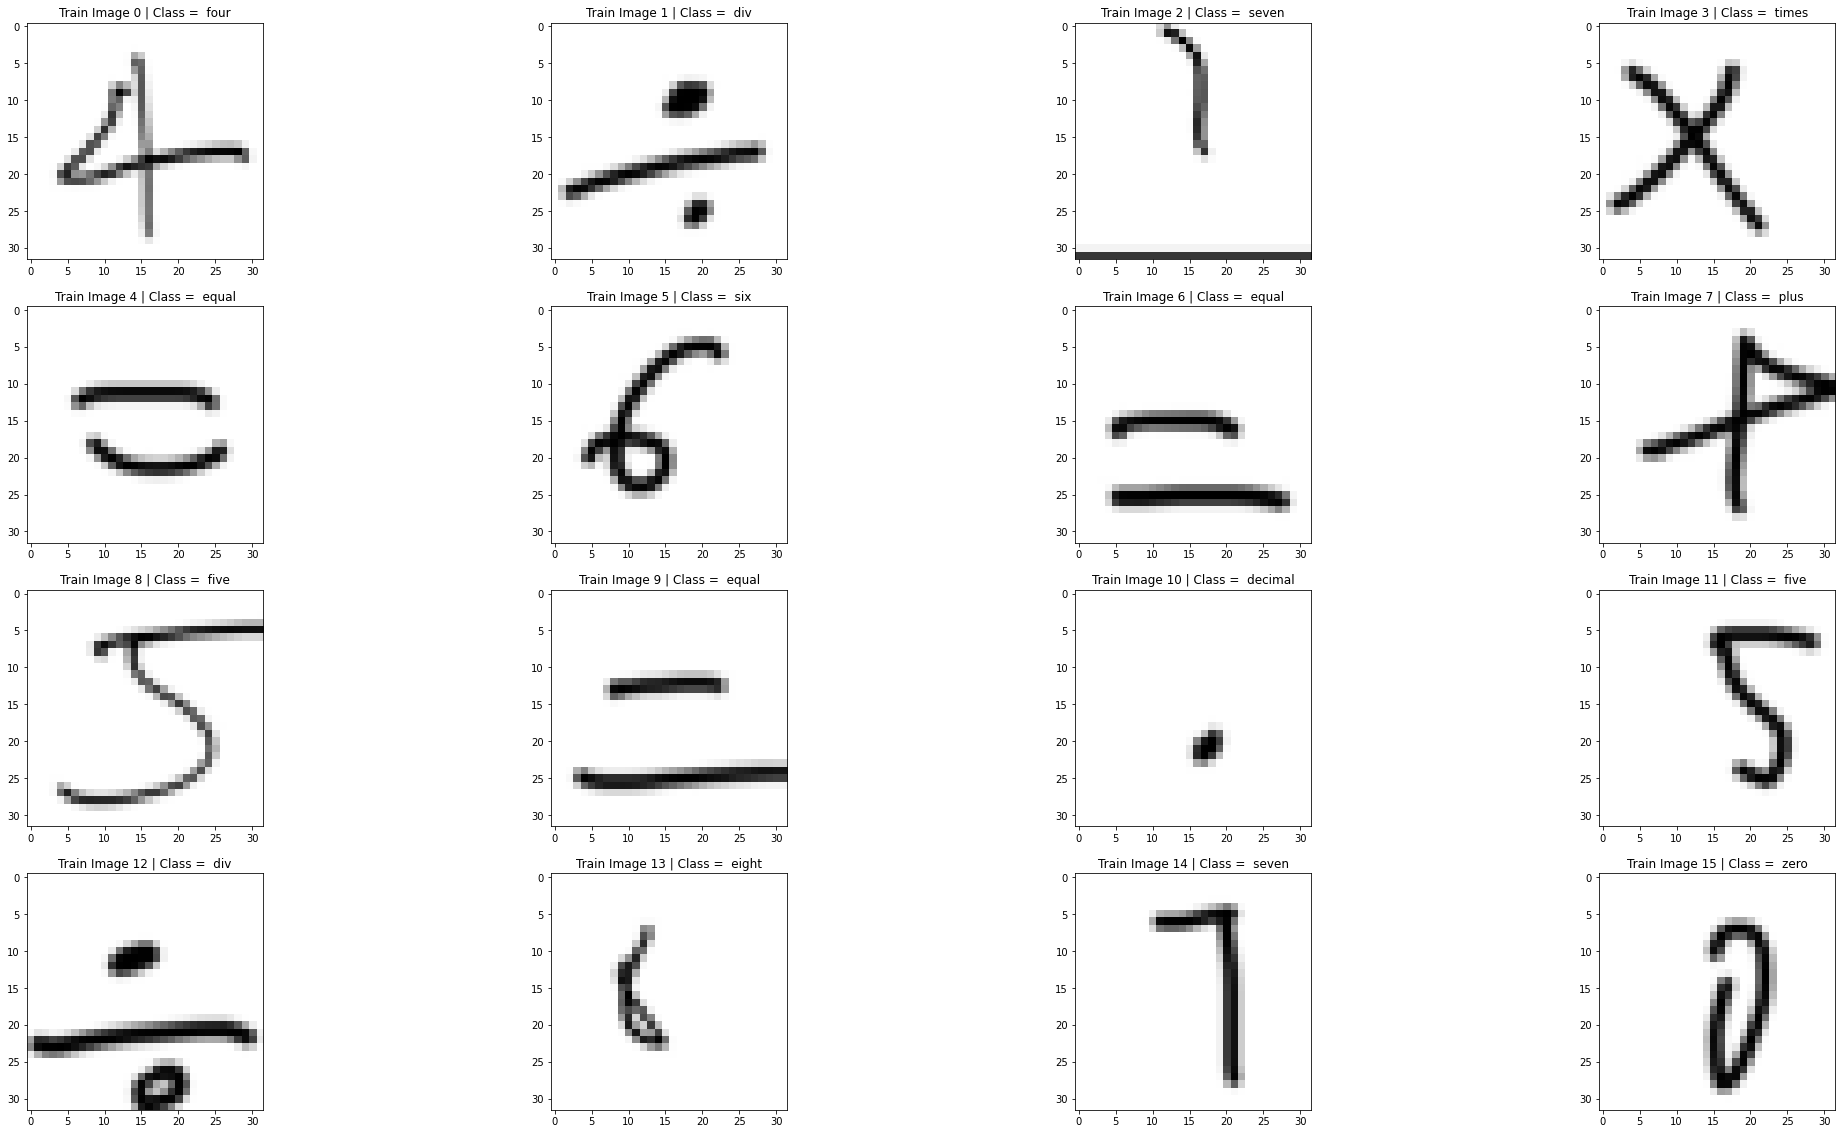

In [ ]:
plt.gray()
for loader_str, loader in [('Train Image', train_dataloader)]:
    data_iter = iter(loader)

    images, labels = next(data_iter)
    print(images.size())
    
    ncol = 4
    nrow = 4
    fig, axes = plt.subplots(figsize=(36,20), ncols=ncol, nrows=nrow)
    for i in range(ncol):
      for j in range(nrow):
        ax = axes[i][j]
        ax.imshow(torch.squeeze(images[i*ncol+j])) #, normalize=False) #, cmap='gray') # ax=ax, 
        ax.set_title('{} {} {} {}'.format(loader_str, i*ncol+j, "| Class = ", train_data.classes[labels[i*ncol+j]]))
    plt.show()

## Figure 2: Amount of Images in Each Class
Bar chart of the number of images in each class in the training dataset.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Number of classes = 16


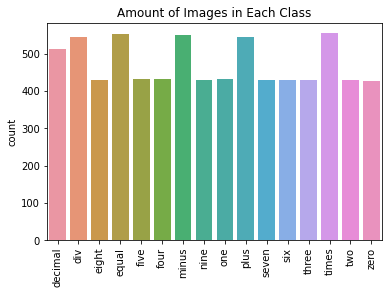

In [ ]:
sns.countplot(train_data.targets)
print("Number of classes =", len(train_data.classes))
plt.xticks(ticks=range(len(train_data.classes)), labels=train_data.classes, rotation=90)
plt.title("Amount of Images in Each Class")
plt.show()

# Design CNN

Our CNN uses pooling, kernels, Rectified Linear Unit (ReLU) activation functions, and fully connections layers to recognize images and sort them into classes. Our model is composed of six layers as shown in Figures 3 and 4: 
1. Convolution
2. Maximum Pooling
3. ReLU Activation Function
4. Linearly Connected Layer
5. ReLU Activation Function
6. Linearly Connected Layer
 
### Layer One
 
The first layer of our model was a convolution using 16 kernels, with dimensions of 3x3 pixels. Each kernel moves one pixel or stride at a time, the image is also padded by one pixel so when the kernel reaches the edge of the image it uses an additional padded pixel. This ensures that the output of using the kernel will be 32x32 pixels, the same size as the original image. Each one of the 16 kernels sweeps over the original image-producing 16 new images each hopefully over training exemplifying certain features like edges. These 16 3x3 pixel kernels are adjusted with each training image resulting in 160 adjustable parameters including an additional bias kernel.
 
### Layer Two
The second layer of our model was a pooling layer that reduced the size of the 16 32x32 pixel images to reduce computation time. We reduced the size of the images by taking the maximum pixel value in a 2x2 pixel area and then shifting or striding that 2x2 pixel area over two to a new area to be pooled. This reduces the size of the 16 32x32 pixel images to 16 16x16 pixel images.
 
### Layer Three
The third layer of our model was the ReLU activation function to reduce linearity because the ReLU function is nonlinear since it is not differentiable when x=0. The ReLU function does not change the amount or size of our images. The ReLU function converts negative pixel values to 0, and any positive pixel value stays the same.
 
### Layer Four
The fourth layer of our model was a linear fully connected layer with 64 nodes. Each pixel in our 16 16x16 pixel images is connected to all of the 64 nodes by a certain weight. These weights are adjusted with each training image resulting in 262,208 adjustable parameters including one additional 16x16 pixel bias image. The result of the fully connected layer is a 64 sized vector.
 
### Layer Five
The fifth layer of our model was another ReLU activation function that does not change the size of the vector. TThe ReLU function converts negative values in the vector to 0, and any positive vector values stay the same.
 
### Layer Six
The sixth layer of our model was another linear fully connected layer, this time the 16 nodes, the same number as the number of our classes. Each of the previous 64 nodes is connected to the 16 nodes by a certain weight. These weights are adjusted each training run resulting in 1040 adjustable parameters including one additional bias node. Each of the final 16 nodes corresponds to the probability of the image belonging to that class. 


## Create CNN
Creates the Convolutional Neural Network (CNN) class, including functions to train the CNN and determine the CNN's loss rate.

In [ ]:
class MyCNN(nn.Module):
    # The init funciton in Pytorch classes is used to keep track of the parameters of the model
    # specifically the ones we want to update with gradient descent + backprop
    # So we need to make sure we keep track of all of them here
    def __init__(self):
        super(MyCNN, self).__init__()
        # layers defined here

        # E.g., considering looking at help(nn.Conv2D).  Draw a picture of what
        # this layer does to the data.

        # note: image_dims[0] will be 1 as there is 1 color channel (Grayscale)
        num_kernels = 16
        self.conv1 = nn.Conv2d(image_dims[0], num_kernels, kernel_size=3, stride=1, padding=1)

        # E.g., considering looking at help(nn.MaxPool2d).  Draw a picture of
        # what this layer does to the data.

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # maxpool_output_size is the total amount of data coming out of that
        # layer.
        self.maxpool_output_size = int(num_kernels * (image_dims[1] / 2) * (image_dims[2] / 2))

        # Add on a fully connected layer (like in our MLP)
        # fc stands for fully connected
        fc1_size = 64
        self.fc1 = nn.Linear(self.maxpool_output_size, fc1_size)

        # We'll use this activation function internally in the network
        self.activation_func = torch.nn.ReLU()

        # Convert our fully connected layer into outputs that we can compare to the result
        fc2_size = len(train_data.classes)
        self.fc2 = nn.Linear(fc1_size, fc2_size)

        # Note: that the output will not represent the probability of the
        # output being in each class.  The loss function we will use
        # `CrossEntropyLoss` will take care of convering these values to
        # probabilities and then computing the log loss with respect to the
        # true label.  We could break this out into multiple steps, but it turns
        # out that the algorithm will be more numerically stable if we do it in
        # one go.  We have included a cell to show you the documentation for
        # `CrossEntropyLoss` if you'd like to check it out.
        
    # The forward function in the class defines the operations performed on a given input to the model
    # and returns the output of the model
    def forward(self, x):
        x = self.conv1(x)
        x = self.pool(x)
        x = self.activation_func(x)
        # this code flattens the output of the convolution, max pool,
        # activation sequence of steps into a vector
        x = x.view(-1, self.maxpool_output_size)
        x = self.fc1(x)
        x = self.activation_func(x)
        x = self.fc2(x)
        return x

    # The loss function (which we chose to include as a method of the class, but doesn't need to be)
    # returns the loss and optimizer used by the model
    def get_loss(self, learning_rate):
      # Loss function
      loss = nn.CrossEntropyLoss()
      # Optimizer, self.parameters() returns all the Pytorch operations that are attributes of the class
      optimizer = optim.Adam(self.parameters(), lr=learning_rate)
      return loss, optimizer
      

## Figure 3: Visualization of the Layers of CNN
Graphically shows the layers of our CNN.

MyCNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4096, out_features=64, bias=True)
  (activation_func): ReLU()
  (fc2): Linear(in_features=64, out_features=16, bias=True)
)


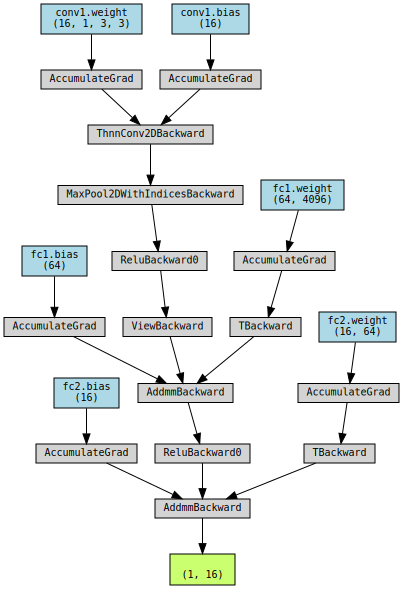

In [ ]:
def visualize_network(net):
    # Visualize the architecture of the model
    # We need to give the net a fake input for this library to visualize the architecture
    fake_input = Variable(torch.zeros((1,image_dims[0], image_dims[1], image_dims[2]))).to(device)
    outputs = net(fake_input)
    # Plot the DAG (Directed Acyclic Graph) of the model
    return make_dot(outputs, dict(net.named_parameters()))

# Define what device we want to use
device = 'cpu' # 'cpu' if we want to not use the gpu

# Initialize the model, loss, and optimization function
net = MyCNN()
# This tells our model to send all of the tensors and operations to the GPU (or keep them at the CPU if we're not using GPU)
net.to(device)

print(net)

visualize_network(net)

## Figure 4: Summarizes Coefficients to be Tuned in CNN
Shows a textual representation of the layers, data shapes, and sizes and the number of adjustable parameters.

In [ ]:
from torchsummary import summary
print(net)
summary(net,(image_dims[0], image_dims[1], image_dims[2]))

MyCNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4096, out_features=64, bias=True)
  (activation_func): ReLU()
  (fc2): Linear(in_features=64, out_features=16, bias=True)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             160
         MaxPool2d-2           [-1, 16, 16, 16]               0
              ReLU-3           [-1, 16, 16, 16]               0
            Linear-4                   [-1, 64]         262,208
              ReLU-5                   [-1, 64]               0
            Linear-6                   [-1, 16]           1,040
Total params: 263,408
Trainable params: 263,408
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

# Train CNN

We trained our CNN with a specified learning rate and number of epochs. We start training the CNN by loading a batch which is a subset of the total training images for the CNN to train on. The CNN began with assigning random numbers for the 16 kernels and random weights for the linear fully connected layers then calculating the loss given those kernels and weights. The path of gradient descent is then determined using Addams optimizer according to the given learning rate. This path of gradient descent informs the changes to the numbers for the 16 kernels and weights for the linear fully connected layers. This process repeats for each image in the batch. Once all of the images in the batch have run through CNN, we have finished a batch and a new batch will be uploaded. Once all of the batches containing all the training images have run through the CNN we have finished an epoch. After each epoch, we ran a validation batch to determine if our CNN improved in validation accuracy. This validation batch would not be trained upon. Then depending on the specified number of epochs we reupload our first batch of images to the already trained CNN and repeat the process.


## Train CNN


In [ ]:
def train_model(net):
    """ Train a the specified network.

        Outputs a tuple with the following four elements
        train_hist_x: the x-values (batch number) that the training set was 
            evaluated on.
        train_loss_hist: the loss values for the training set corresponding to
            the batch numbers returned in train_hist_x
        test_hist_x: the x-values (batch number) that the test set was 
            evaluated on.
        test_loss_hist: the loss values for the test set corresponding to
            the batch numbers returned in test_hist_x
    """ 
    loss, optimizer = net.get_loss(learning_rate)
    # Define some parameters to keep track of metrics
    print_every = 20
    idx = 0
    train_hist_x = []
    train_loss_hist = []
    test_hist_x = []
    test_loss_hist = []
  
    training_start_time = time.time()
    # Loop for n_epochs
    for epoch in range(n_epochs):
        running_loss = 0.0
        start_time = time.time()
        total_test_loss = 0
        for inputs, labels in test_loader:

            # Wrap tensors in Variables
            inputs, labels = Variable(inputs).to(device), Variable(labels).to(device)

            # Forward pass
            test_outputs = net(inputs)
            test_loss_size = loss(test_outputs, labels)
            total_test_loss += test_loss_size.data.item()
        for i, data in enumerate(train_loader, 0):

            # Get inputs in right form
            inputs, labels = data
            inputs, labels = Variable(inputs).to(device), Variable(labels).to(device)
            
            # In Pytorch, We need to always remember to set the optimizer gradients to 0 before we recompute the new gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = net(inputs)
            
            # Compute the loss and find the loss with respect to each parameter of the model
            loss_size = loss(outputs, labels)
            loss_size.backward()
            
            # Change each parameter with respect to the recently computed loss.
            optimizer.step()

            # Update statistics
            running_loss += loss_size.data.item()
            
            # Print every 20th batch of an epoch
            if (i % print_every) == print_every-1:
                print("Epoch {}, Iteration {}\t train_loss: {:.2f} took: {:.2f}s".format(
                    epoch + 1, i+1,running_loss / print_every, time.time() - start_time))
                # Reset running loss and time
                train_loss_hist.append(running_loss / print_every)
                train_hist_x.append(idx)
                running_loss = 0.0
                start_time = time.time()
            idx += 1

        # At the end of the epoch, do a pass on the test set

        test_loss_hist.append(total_test_loss / len(test_loader))
        test_hist_x.append(idx)
        print("Validation loss = {:.2f}".format(
            total_test_loss / len(test_loader)))

    print("Training finished, took {:.2f}s".format(
        time.time() - training_start_time))
    return train_hist_x, train_loss_hist, test_hist_x, test_loss_hist

In [ ]:
# Define training parameters
net = MyCNN()
# This tells our model to send all of the tensors and operations to the GPU (or keep them at the CPU if we're not using GPU)
net.to(device)
# Training Parameters
batch_size = 32
learning_rate = 0.01
n_epochs = 7
# Get our data into the mini batch size that we defined
n_train_samples = len(train_data) # How many training images to use
n_test_samples = len(test_data) # How many test images to use
test_sampler = SubsetRandomSampler(np.arange(n_test_samples, dtype=np.int64))
train_sampler = SubsetRandomSampler(np.arange(n_train_samples, dtype=np.int64))
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=train_sampler, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=128, sampler=test_sampler, num_workers=2)


In [ ]:
 train_hist_x, train_loss_hist, test_hist_x, test_loss_hist = train_model(net)

Epoch 1, Iteration 20	 train_loss: 4.16 took: 1.77s
Epoch 1, Iteration 40	 train_loss: 2.74 took: 0.66s
Epoch 1, Iteration 60	 train_loss: 2.53 took: 0.68s
Epoch 1, Iteration 80	 train_loss: 2.14 took: 0.67s
Epoch 1, Iteration 100	 train_loss: 1.84 took: 0.61s
Epoch 1, Iteration 120	 train_loss: 1.59 took: 0.64s
Epoch 1, Iteration 140	 train_loss: 1.52 took: 0.64s
Epoch 1, Iteration 160	 train_loss: 1.32 took: 0.63s
Epoch 1, Iteration 180	 train_loss: 1.41 took: 0.67s
Epoch 1, Iteration 200	 train_loss: 1.29 took: 0.63s
Epoch 1, Iteration 220	 train_loss: 1.26 took: 0.62s
Validation loss = 2.78
Epoch 2, Iteration 20	 train_loss: 1.03 took: 1.68s
Epoch 2, Iteration 40	 train_loss: 0.93 took: 0.63s
Epoch 2, Iteration 60	 train_loss: 0.94 took: 0.62s
Epoch 2, Iteration 80	 train_loss: 0.85 took: 0.62s
Epoch 2, Iteration 100	 train_loss: 0.96 took: 0.69s
Epoch 2, Iteration 120	 train_loss: 0.89 took: 0.62s
Epoch 2, Iteration 140	 train_loss: 0.92 took: 0.67s
Epoch 2, Iteration 160	 train_l

## Figure 5: Training and Validation Loss of CNN by Batch Number
Visualizes the CNN's learning by plotting the training and validation loss by batch number.

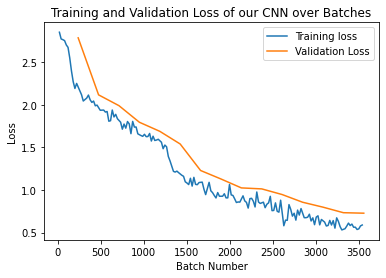

In [ ]:
plt.plot(train_hist_x,train_loss_hist)
plt.plot(test_hist_x,test_loss_hist)
plt.legend(['Training loss', 'Validation Loss'])
plt.xlabel('Batch Number')
plt.ylabel('Loss')
plt.title("Training and Validation Loss of our CNN over Batches")
plt.show()

## Accuracy of the Trained CNN
Determines the accuracy of the final trained CNN for both the training and the testing datasets.

In [ ]:
def get_accuracy(net, loader):
    n_correct = 0
    n_total = 0
    for i, data in enumerate(loader, 0):
        # Get inputs in right form
        inputs, labels = data
        inputs, labels = Variable(inputs).to(device), Variable(labels).to(device)

        # Forward pass
        outputs = net(inputs)
        n_correct += np.sum(np.argmax(outputs.cpu().detach().numpy(), axis=1) == labels.cpu().numpy())
        n_total += labels.shape[0]
    return n_correct/n_total
print("Train accuracy is", get_accuracy(net, train_loader))
print("Test accuracy is", get_accuracy(net, test_loader))

Train accuracy is 0.8450443297604869
Test accuracy is 0.7980198019801981


## Figure 6: Actual and Predicted Classes of Testing Images
Displays 16 randomly sampled testing images labeled by both the predicted and actual classes.

torch.Size([32, 1, 32, 32])
predictions [0, 9, 14, 8, 3, 6, 4, 9, 6, 10]


<Figure size 432x288 with 0 Axes>

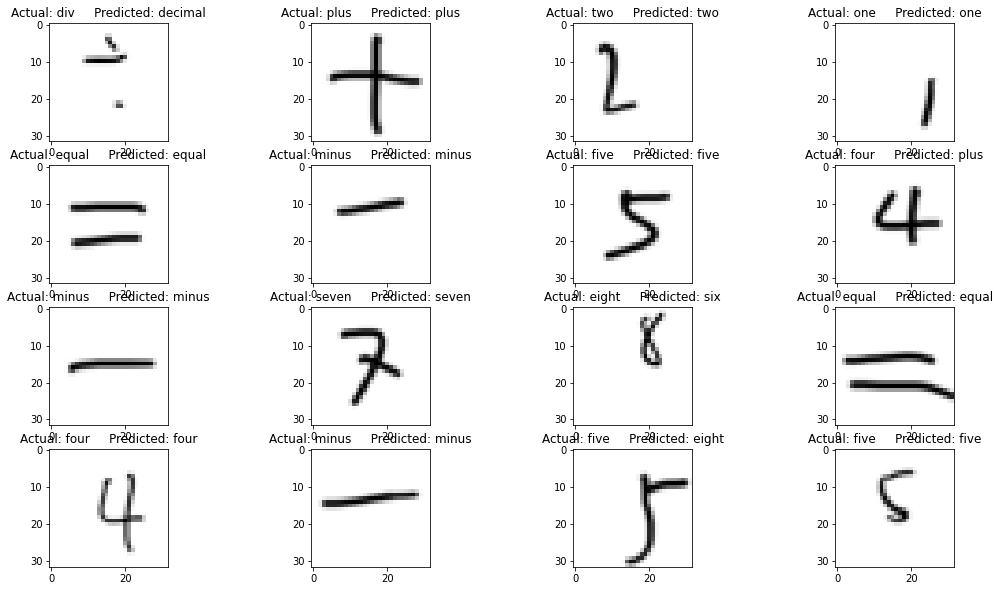

In [ ]:
plt.gray()
for loader_str, loader in [('Test Image', test_dataloader)]:
    data_iter = iter(loader)

    images, labels = next(data_iter)
    class_scores = [net(Variable(image.unsqueeze(0)).to(device)) for image in images]
    predictions = [np.argmax(class_score.cpu().detach().numpy()) for class_score in class_scores]
    print(images.size())
    print("predictions", predictions[0:10])

    ncol = 4
    nrow = 4
    fig, axes = plt.subplots(figsize=(18,10), ncols=ncol, nrows=nrow)
    for i in range(ncol):
      for j in range(nrow):
        ax = axes[i][j]
        ax.imshow(torch.squeeze(images[i*ncol+j])) #, normalize=False) #, cmap='gray') # ax=ax, 
        # print("train_data.classes[labels[i*ncol+j]]", train_data.classes[labels[i*ncol+j]])
        # print("train_data.classes[predictions[i*ncol+j]]", train_data.classes[predictions[i*ncol+j]])
        ax.set_title("Actual: " + test_data.classes[labels[i*ncol+j]] + "     Predicted: " + test_data.classes[predictions[i*ncol+j]])
    plt.show()

## Optimising Learning Rate and Number of Epochs to Produce the Highest Training Accuracy
To find optimize the learning rate and number of epochs, for testing accuracy we swept the learning rate and number of epochs creating a new CNN each time. Through this testing, we determined learning rates around 0.0075-0.001 and a higher number of epochs between 5-7 was better. The best accuracy achieved through varying the learning rate and number of epochs was about 85% testing accuracy at a learning rate of 0.001, and 7 epochs. (The following code cell takes about 10 minutes to run)


In [ ]:
# Define training parameters
batch_size = 32

# Get our data into the mini batch size that we defined
n_train_samples = len(train_data) # How many training images to use
n_test_samples = len(test_data) # How many test images to use
All_Data = pd.DataFrame(columns =['n_epochs','learning_rate','train_accuracy','test_accuracy'])
#All_Data.columns =['n_epochs','learning_rate','train_accuracy','test_accuracy']
learning_rates = [0.001, 0.0025, 0.005, 0.0075, 0.01]
for n_epochs in [1,3,5,7]:
  for learning_rate in learning_rates:
    net = MyCNN()
    # This tells our model to send all of the tensors and operations to the GPU (or keep them at the CPU if we're not using GPU)
    net.to(device)
    test_sampler = SubsetRandomSampler(np.arange(n_test_samples, dtype=np.int64))
    train_sampler = SubsetRandomSampler(np.arange(n_train_samples, dtype=np.int64))
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=train_sampler, num_workers=2)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=128, sampler=test_sampler, num_workers=2)

    train_accuracy = []
    test_accuracy = []
    train_hist_x, train_loss_hist, test_hist_x, test_loss_hist = train_model(net)
    All_Data.loc[len(All_Data.index)] = [n_epochs, learning_rate, get_accuracy(net, train_loader), get_accuracy(net, test_loader)]


Epoch 1, Iteration 20	 train_loss: 2.80 took: 1.76s
Epoch 1, Iteration 40	 train_loss: 2.78 took: 0.63s
Epoch 1, Iteration 60	 train_loss: 2.74 took: 0.64s
Epoch 1, Iteration 80	 train_loss: 2.70 took: 0.69s
Epoch 1, Iteration 100	 train_loss: 2.62 took: 0.64s
Epoch 1, Iteration 120	 train_loss: 2.54 took: 0.65s
Epoch 1, Iteration 140	 train_loss: 2.40 took: 0.62s
Epoch 1, Iteration 160	 train_loss: 2.36 took: 0.63s
Epoch 1, Iteration 180	 train_loss: 2.21 took: 0.62s
Epoch 1, Iteration 200	 train_loss: 2.04 took: 0.65s
Epoch 1, Iteration 220	 train_loss: 1.96 took: 0.61s
Validation loss = 2.79
Training finished, took 8.61s
Epoch 1, Iteration 20	 train_loss: 2.80 took: 1.66s
Epoch 1, Iteration 40	 train_loss: 2.66 took: 0.61s
Epoch 1, Iteration 60	 train_loss: 2.46 took: 0.63s
Epoch 1, Iteration 80	 train_loss: 2.24 took: 0.63s
Epoch 1, Iteration 100	 train_loss: 2.00 took: 0.64s
Epoch 1, Iteration 120	 train_loss: 1.78 took: 0.62s
Epoch 1, Iteration 140	 train_loss: 1.65 took: 0.67s
E

## Figure 7: Heatmap of Testing Accuracy as Epochs vs. Learning Rate

Displays a heatmap showing the different testing accuracies for CNNs with different learning rates and number of epochs. The areas that have very low testing accuracies we believe are due to low learning rates leading the CNN to get stuck in local minima.

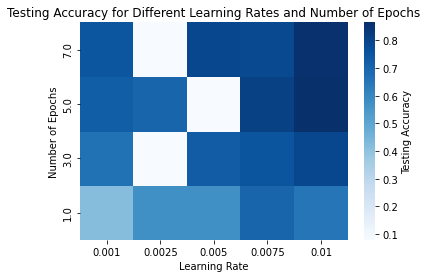

In [ ]:
piv = All_Data[['n_epochs','learning_rate','test_accuracy']].pivot_table(All_Data[['n_epochs','learning_rate','test_accuracy']], index='n_epochs', columns='learning_rate')
piv.columns = piv.columns.droplevel(0)
ax = sns.heatmap(piv, cbar_kws={'label': 'Testing Accuracy'},cmap="Blues")
ax.set(title="Testing Accuracy for Different Learning Rates and Number of Epochs",
      xlabel="Learning Rate",
      ylabel="Number of Epochs")
ax.invert_yaxis()

# Conclusion

## Specific Applications
Being able to recognize handwritten math equations is incredibly useful, particularly in education. Students could take pictures of their written work, run a machine-learning algorithm to convert their equations into some computerized form and then upload them to a calculator or computational knowledge engine such as WolframAlpha for validation. Recognizing handwritten math could convert a student's written work into Latex, which we think would be helpful for teachers given that they would not have to worry about detrimental image quality or handwriting that could impede their ability to read the student’s work. Also, in this increasingly virtual connected world, being able to rapidly convert math concepts on paper into a digital form could improve in sharing and collaboration in virtual spaces. Other possible applications of handwritten digit recognition include mail sorting, bank check processing, form data entry, etcetera. 

## Implications
Some of the implications of machine learning algorithms that could recognize math equations stem from the fact that they will not be completely accurate and may not recognize certain handwritings or styles. Also to be able to recognize math equations, you first need to take and send an image of the equation which depending on one's access to technology may be difficult. This would limit certain groups' access to this beneficial machine learning technology.
 
## Limitations and Next Steps
 
There are many limitations to our algorithm, but mainly that it cannot slice an image of an equation into its different symbols to be recognized. Given an equation that is oriented horizontally without any vertically arranged symbols, it would be possible to crop each individual symbol, run our CNN to get each symbol's predicted identity, and from that reconstruct the full equation in latex form.
 
Our current model can only recognize digits and a select set of symbols so it is limited to uses that only require those symbols. Since middle school, we have been learning to work with variables and more complex math on which our current algorithm would not be applicable. To expand the types of mathematics that this algorithm can work on, we would include Latin and Greek alphabet letters for variables as well as other math symbols such as parentheses, inequalities, and more.
 
In summary, if we had more time to take this project further we would:
- Write an additional algorithm to slice equations by symbol
- Expand our list of classes to include more symbols and letters
 

